In [488]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI 
from langgraph.prebuilt import create_react_agent
from langchain.prompts import PromptTemplate
from langchain.chat_models import init_chat_model
from langgraph.func import entrypoint
from langgraph.store.memory import InMemoryStore
from langmem import create_memory_store_manager
from pydantic import BaseModel
from typing import Optional
from langmem import create_manage_memory_tool, create_search_memory_tool


In [489]:
from dotenv import load_dotenv

In [490]:
load_dotenv()

True

In [491]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [492]:
class TravelFact(BaseModel):
    """Facts extracted from user conversation during travel planning."""
    subject: str  
    predicate: str  
    destination: str  
    context: Optional[str] = None  


In [493]:
# store = InMemoryStore(  
#     index={
#         "dims": 1536,
#         "embed": "openai:text-embedding-3-small",
#     }
# )
# manager = create_memory_store_manager(
#     model,
#     namespace=("travel_nmspc"),  
#     schemas=[TravelFact],
#     instructions="Extract all information during travel planning",
#     enable_inserts=True,
#     enable_deletes=True,
# )

In [494]:
class QueryTypeSchema(BaseModel):
    which: Literal["NEW_QUERY", "FOLLOW_UP"]

In [495]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    intent: Literal["plan_trip", "travel_tips", None]
    destination: str
    dates: str
    duration: int
    budget: float
    itinerary: list
    tips: str
    which:str



In [496]:
from pydantic import BaseModel, Field
from typing import Optional, List

class UserPreferences(BaseModel):
    activities: Optional[List[str]] = Field(default_factory=list)

class TravelQuery(BaseModel):
    destination: Optional[str] = Field(description="User's desired travel destination")
    duration: Optional[int] = Field(description="Number of days for the trip")
    preferences: Optional[UserPreferences] = Field(default_factory=UserPreferences)
    intent: Optional[str] = Field(description="User's intent, e.g., 'plan_trip' or 'travel_tips'")


In [497]:
# store = InMemoryStore(
#     index={"dims": 1536, "embed": "openai:text-embedding-3-small"},
# )

# # 2) The memory‐manager agent, wired to that store
# def _memory_prompt(state: State):
#     recent = store.search(("memories",), query=state["messages"][-1].content, top_k=5)
#     snippet = "\n".join("- " + m.value["content"] for m in recent)
#     system = f"""
#     You are a memory‐manager assistant. Here are the top‐5 related memories:
#     {snippet}

#     Use the tools to create, update, or delete entries as needed.
#     """
#     return [{"role": "system", "content": system.strip()}] + state["messages"]

# manager = create_react_agent(
#     model=model,
#     prompt=_memory_prompt,
#     tools=[
#         create_manage_memory_tool(namespace=("memories",)),
#         create_search_memory_tool(namespace=("memories",)),
#     ],
#     store=store,               # <— crucial: gives the tools a real store
#     # checkpointer=InMemorySaver() # optional, but helps with retries
# )


In [498]:
# async def new_or_prev_question_agent(state: State) -> State:
#     # Wrap the base LLM for structured output
#     llm = model.with_structured_output(QueryTypeSchema)

#     # System prompt
#     system_msg = (
#         "You are a travel-planning assistant. Decide whether the user's latest message is:\n"
#         "- NEW_QUERY      (a brand-new travel planning request), or\n"
#         "- FOLLOW_UP      (a follow-up or reference to something discussed earlier).\n\n"
#         "Respond *only* with JSON matching this schema:\n"
#         "{ \"which\": \"NEW_QUERY\" | \"FOLLOW_UP\" }\n"
#     )

#     # Build the messages array
#     messages = [{"role": "system", "content": system_msg.strip()}] + state["messages"]

#     # *** Pass `messages` directly to ainvoke, not wrapped in a dict ***
#     parsed: QueryTypeSchema = await llm.ainvoke(messages)
#     print("parsed.which -->",parsed.which)
#     # Update state
#     updated = dict(state)
#     updated["which"] = parsed.which
#     return updated

In [499]:
from langchain.prompts import PromptTemplate

async def extract_user_info_node(state: State) -> State:
    # Define the custom prompt directly
    prompt = (
        "You are a travel assistant. You MUST only suggest destinations from [thailand, bali, dubai]. "
        "Even if the user says beach or island, DO NOT invent other destinations like Maldives. "
        "Map user preferences to the closest among Thailand, Bali, or Dubai.\n"
        "User message: {user_message}\n"
        "Suggest a destination and provide any preferences like activities (e.g., beach, adventure)."
    )
    
    # Use the model to process the user message with the custom prompt
    user_message = state["messages"][-1].content  # Accessing user input

    # Format the prompt with the user's message
    formatted_prompt = prompt.format(user_message=user_message)
    llm = model.with_structured_output(TravelQuery)
    # manager.ainvoke({"messages": [{"role": "user", "content": user_message}]})
    
    try:
        # Now directly invoking the model with the custom prompt
        parsed = llm.invoke(formatted_prompt)
    except Exception as e:
        raise ValueError(f"Failed to parse user input: {e}")
    print("Model Response:", parsed)

    # Update the state with parsed details
    updated_state = dict(state)
    updated_state["destination"] = parsed.destination
    updated_state["duration"] = parsed.duration
    updated_state["preferences"] = parsed.preferences.dict() if parsed.preferences else {}
    updated_state["intent"] = parsed.intent
    return updated_state


In [500]:
async def plan_trip_node(state: State) -> State:
    print("inside the node")
    destination = state["destination"].lower()
    duration = state["duration"]
    preferences = state.get("preferences", {})

    # Validate supported destinations
    if destination not in ["thailand", "dubai", "bali"]:
        raise ValueError(f"Unsupported destination {destination}.")

    # 🛠 Build a *specific instruction* for the agent
    user_prompt = (
        f"You are planning a {duration}-day travel itinerary for {destination.title()}.\n"
        f"Use the available tools to create a day-by-day plan.\n"
        f"Each day should include 2-3 activities.\n"
    )
    if preferences.get("activities"):
        user_prompt += f"The user prefers activities related to: {', '.join(preferences['activities'])}.\n"
    else:
        user_prompt += "If no preferences are given, suggest a balanced mix of sightseeing, relaxation, and adventure.\n"

    user_prompt += (
        "Return the plan in structured format: each day number followed by the list of activities planned.\n"
        "Prioritize matching user preferences where possible.\n"
    )

    # 👇 Now initialize MCP client inside the node
    print("before calling MCP Servere sa")
    async with MultiServerMCPClient(
        {
            "travel": {
                "command": "python",
                "args": ["/Users/praveenreddy/langraph-mcp-langmem/mcp-server/travel_itinerary_planner_server/travel_itinerary_plan.py"],
                "transport": "stdio",
            }
        }
    ) as client:
        print("tools --> ",client.get_tools())
        agent = create_react_agent(
            model,
            client.get_tools()
        )

        response = await agent.ainvoke(
            {"messages": [{"role": "user", "content": user_prompt}]}
        )
        print("response -->",response)

    updated_state = dict(state)
    updated_state["itinerary"] = response
    return updated_state


In [501]:
async def travel_tips_node(state: State) -> State:
    destination = state["destination"].lower()
    print("inside travel tips method ")
    # Predefined tips database
    destination_tips = {
        "thailand": [
            "Carry light cotton clothes; it's usually hot and humid.",
            "Respect local customs when visiting temples (dress modestly).",
            "Beware of scams — always agree on tuk-tuk fares beforehand.",
            "Carry cash; not everywhere accepts cards.",
            "Try street food but stick to stalls with high turnover for freshness."
        ],
        "dubai": [
            "Dress modestly in public places to respect local culture.",
            "Public transport (metro, buses) is cheap and efficient.",
            "Summer (June-Aug) can be extremely hot; best to visit Oct-April.",
            "Tipping is appreciated but not mandatory.",
            "Book popular attractions like Burj Khalifa in advance."
        ],
        "bali": [
            "Scooters are a common way to get around but drive cautiously.",
            "Respect religious ceremonies; never stand higher than priests.",
            "Bring reef-safe sunscreen to protect marine life.",
            "Bargaining is common in local markets.",
            "Tap water is not drinkable — stick to bottled water."
        ],
    }

    if destination not in destination_tips:
        raise ValueError(f"Sorry, no travel tips available for {destination}.")

    tips = destination_tips[destination]

    updated_state = dict(state)
    updated_state["tips"] = tips
    return updated_state


In [502]:
# def get_info_from_memory(state:State):
#     # store = InMemoryStore(
#     # index={
#     #     "dims": 1536,
#     #     "embed": "openai:text-embedding-3-small",
#     #     }
#     # )
#     # my_llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")
#     # def prompt(state):
#     #     """Prepare messages with context from existing memories."""
#     #     memories = store.search(
#     #         ("memories",),
#     #         query=state["messages"][-1].content,
#     #     )
#     #     system_msg = f"""You are a memory manager. Extract and manage all important knowledge, rules, and events using the provided tools.
#     #         Existing memories:
#     #         <memories>
#     #         {memories}
#     #         </memories>

#     #         Use the manage_memory tool to update and contextualize existing memories, create new ones, or delete old ones that are no longer valid.
#     #         You can also expand your search of existing memories to augment using the search tool."""
#     #     return [{"role": "system", "content": system_msg}, *state["messages"]]


#     # # Create the memory extraction agent
#     # manager = create_react_agent(
#     #     model=model,
#     #     prompt=prompt,
#     #     tools=[
#     #         # Agent can create/update/delete memories
#     #         create_manage_memory_tool(namespace=("memories",)),
#     #         create_search_memory_tool(namespace=("memories",)),
#     #     ],
#     #     store=store,
#     #     checkpointer=InMemoryStore()
#     # )
#     messages_init = state['messages'][0].content
#     messages = [
#         {
#             "role": "user",
#             "content": f"{messages_init}",
#         }
#     ]

#     print("mem messages",messages)
#     print("con --",messages)
#     # response = model.invoke(
#     #     [
#     #         {
#     #             "role": "system",
#     #             "content": "You are a helpful assistant.",
#     #         },
#     #         *messages,
#     #     ]
#     # )
#     # res = manager.invoke({"messages": messages})
#     res = manager.invoke({"messages": messages})
#     print("memeory response is --> ",res)
#     return res
    

In [503]:
# def route_query(state: State)->Literal["extract_user_info_node", "get_info_from_memory"]:
#     if state["which"] == "NEW_QUERY":
#         return "extract_user_info_node"
#     else:
#         return "get_info_from_memory"

In [504]:

graph = StateGraph(State)

In [505]:
# graph.add_node("new_or_prev_question_agent", new_or_prev_question_agent)
graph.add_node("extract_user_info_node", extract_user_info_node)
graph.add_node("plan_trip_node", plan_trip_node)
graph.add_node("travel_tips_node", travel_tips_node)
# graph.add_node("get_info_from_memory", get_info_from_memory)


# graph.add_edge(START, "new_or_prev_question_agent")
graph.add_edge(START, "extract_user_info_node")
graph.add_edge("extract_user_info_node","plan_trip_node")
graph.add_edge("plan_trip_node", "travel_tips_node")
graph.add_edge("travel_tips_node", END)
# graph.add_edge("get_info_from_memory",END)
# graph.add_conditional_edges(
#     "new_or_prev_question_agent",
#     path=route_query,
# )

# graph.add_edge("extract_user_info_node","plan_trip_node")


In [506]:
app = graph.compile()

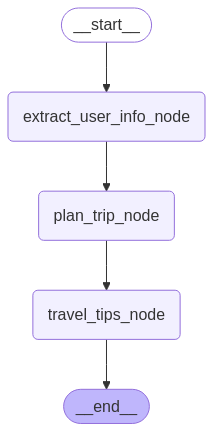

In [507]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [508]:
response = await app.ainvoke(
    {"messages": [{"role": "user", "content": "I like the beach area and i want to spend 3-4 days so, anything you can suggest ?  "}]}
)

Model Response: destination='Bali' duration=4 preferences=UserPreferences(activities=['beach', 'surfing', 'relaxation']) intent='plan_trip'
inside the node
before calling MCP Servere sa


/var/folders/s8/1949x5zs6xj63rt734q09jzr0000gn/T/ipykernel_55366/3371812093.py:32: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  updated_state["preferences"] = parsed.preferences.dict() if parsed.preferences else {}


tools -->  [StructuredTool(name='plan_thailand', description='\n    Generate a detailed multi-day travel itinerary for Thailand.\n\n    Args:\n    - request (PlanRequest): \n        - days: Number of days to plan for.\n        - preferences: Optional user preferences like type of activities they enjoy.\n\n    Returns:\n    - List[Itinerary]: A list containing the day-by-day plan with 2-3 activities per day.\n    ', args_schema={'$defs': {'PlanRequest': {'description': 'Request model for planning a travel itinerary.\n\nAttributes:\n- days (int): Number of days the user wants the itinerary for.\n- preferences (Dict[str, List[str]]): Optional user preferences, such as preferred activities (e.g., beaches, adventure).', 'properties': {'days': {'title': 'Days', 'type': 'integer'}, 'preferences': {'additionalProperties': {'items': {'type': 'string'}, 'type': 'array'}, 'default': {}, 'title': 'Preferences', 'type': 'object'}}, 'required': ['days'], 'title': 'PlanRequest', 'type': 'object'}}, '

In [182]:

# async def chat(messages: list):
#     response = await app.ainvoke(
#         {"messages": [{"role": "user", "content": "I like the beach area and i want to spend 3-4 days so, anything you can suggest ?  "}]}
#     )

#     # Extract and store triples (Uses store from @entrypoint context)
#     manager.invoke({"messages": messages}) 
#     return response

In [509]:
print(response['itinerary']['messages'][-1].content)

Here is a 4-day travel itinerary for Bali:

- **Day 1:**
  1. Sunrise at Mount Batur
  2. Tegalalang rice terraces
  3. Beach day at Kuta

- **Day 2:**
  1. Tegalalang rice terraces
  2. Beach day at Kuta
  3. Ubud monkey forest

- **Day 3:**
  1. Beach day at Kuta
  2. Ubud monkey forest
  3. Waterfall hike

- **Day 4:**
  1. Ubud monkey forest
  2. Waterfall hike
  3. Temples of Uluwatu

This itinerary offers a balanced mix of sightseeing, relaxation, and adventure, ensuring a memorable experience in Bali.


In [510]:
response['tips']

['Scooters are a common way to get around but drive cautiously.',
 'Respect religious ceremonies; never stand higher than priests.',
 'Bring reef-safe sunscreen to protect marine life.',
 'Bargaining is common in local markets.',
 'Tap water is not drinkable — stick to bottled water.']